In [2]:
#MNIST 데이터와 PCA 기법을 활용해 차원 축소에 대해 알아 봅시다!

In [7]:
# 메인 라이브러리 불러오기
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

# 시각화 관련 라이브러리 불러오기
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

# 데이터 준비, 모델 평가 관련 라이브러리
from sklearn import preprocessing as ppp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# 알고리즘 관련 라이브러리 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [8]:
# MNIST data load

current_path = os.getcwd()
file = os.path.sep.join(['','mnist.pkl.gz'])

# 본인의 구글 드라이브(현재 디렉토리)에 mnist.pkl.gz 파일이 올라가 있어야 함!
# colab의 경우 content 폴더 바로 아래에 들어가면 됨

f = gzip.open(current_path+file, 'rb')

train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [10]:
#1] MNIST 데이터 알아보기

In [15]:
# .shape을 활용해 각각의 데이터 크기를 확인합니다!

# X_train, y_train
print("Shape of X_train:      ", X_train.shape)
print("Shape of y_train:      ", y_train.shape)

# X_validation, y_validation (DIY!)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)

# X_test, y_test (DIY!)
print("Shape of X_test:       ", X_test.shape)
print("Shape of y_test:       ", y_test.shape)

Shape of X_train:       (50000, 784)
Shape of y_train:       (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:        (10000, 784)
Shape of y_test:        (10000,)


In [16]:
# Pandas dataframe 형태로 데이터를 변환합니다.

train_index = range(0, len(X_train))
validation_index = range(len(X_train), len(X_train) + len(X_validation))
test_index = range(len(X_train)+len(X_validation),
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.Series(data=y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.Series(data=y_validation, index=validation_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.Series(data=y_test, index=test_index)

In [17]:
#X는 input, y는 label을 의미합니다.

#즉, X_train 내의 이미지가 어떤 숫자의 손글씨인지는 y_train에 담겨 있습니다.

In [18]:
# 2] Label 확인해 보기

In [19]:
# Label 확인해 보기 (DIY!)
y_train.head()

0    5
1    0
2    4
3    1
4    9
dtype: int64

In [20]:
# 3] X_train 이미지 하나하나 열어 보기
#아래에 새롭게 정의된 view_digit() 함수를 통해
#앞서 확인한 Label이 정말 정확한지 확인해 봅시다!

In [21]:
# 이미지 시각화 함수 view_digit()
def view_digit(example):
    label = y_train.loc[example]
    image = X_train.loc[example,:].values.reshape([28, 28])
    plt.title('Example: %d     /     Label: %d'%(example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

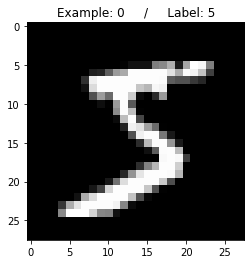

In [22]:
# 첫번째 X_train 이미지 열기

# 제대로 함수가 정의됐다면 '5' 를 손으로 쓴 이미지가 보여야 합니다!
view_digit(0)

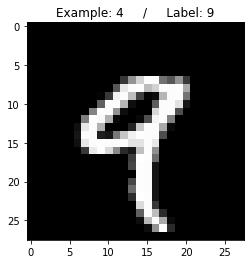

In [23]:
# 다섯번째 X_train 이미지 열기 (DIY!)

view_digit(4)

In [24]:
#4] PCA
#PCA를 통해 만들어 낸 주성분 별로 얼마만큼의 분산을 설명하는지 확인할 수 있습니다!

#해당 데이터는 pca.explained_variance_ratio_ 를 통해 확인할 수 있습니다.

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 784)

In [26]:
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [27]:
# pca.explained_variance_ratio_
# 전체 주성분을 모두 사용하는 경우

print("전체 784개의 주성분에 의해 설명되는 분산(정보량)의 비율은, ",
      sum(pca.explained_variance_ratio_), "입니다.")

전체 784개의 주성분에 의해 설명되는 분산(정보량)의 비율은,  0.9999999871732004 입니다.


In [28]:
#이론상, 전체 784개 주성분을 모두 사용하면 전체 정보량 전부를 유지해야 합니다.

#그렇다면, 그 중 일부만 사용할 경우는 어떨까요?

#아래에 첫 10개의 주성분에 의해 설명되는 정보량의 비율을 계산할 수 있는 코드를 작성해 두었습니다.

#이를 바탕으로 20개, 50개, 100개, 200개, 300개를 사용할 때는 얼마만큼의 정보량을 보존하는지 확인해 보세요!

#(importanceOfPrincipalComponents: pca.explained_variance_ratio_를 Pandas data frame으로 변환한 것입니다.)

In [29]:
# If X is not 784,

importanceOfPrincipalComponents = pd.DataFrame(data=pca.explained_variance_ratio_)

importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print("첫 10개의 주성분에 의해 설명되는 분산(정보량)의 비율은,",
      importanceOfPrincipalComponents.loc[:, 0:9].sum(axis=1).values, "입니다.")

# DIY! (???를 채워 주세요.)
print("첫 20개의 주성분에 의해 설명되는 분산(정보량)의 비율은,",
      importanceOfPrincipalComponents.loc[:, 0:19].sum(axis=1).values, "입니다.")
print("첫 50개의 주성분에 의해 설명되는 분산(정보량)의 비율은,",
      importanceOfPrincipalComponents.loc[:, 0:49].sum(axis=1).values, "입니다.")
print("첫 100개의 주성분에 의해 설명되는 분산(정보량)의 비율은,",
      importanceOfPrincipalComponents.loc[:, 0:99].sum(axis=1).values, "입니다.")
print("첫 200개의 주성분에 의해 설명되는 분산(정보량)의 비율은,",
      importanceOfPrincipalComponents.loc[:, 0:199].sum(axis=1).values, "입니다.")
print("첫 300개의 주성분에 의해 설명되는 분산(정보량)의 비율은,",
      importanceOfPrincipalComponents.loc[:, 0:299].sum(axis=1).values, "입니다.")

첫 10개의 주성분에 의해 설명되는 분산(정보량)의 비율은, [0.48876226] 입니다.
첫 20개의 주성분에 의해 설명되는 분산(정보량)의 비율은, [0.6439802] 입니다.
첫 50개의 주성분에 의해 설명되는 분산(정보량)의 비율은, [0.8248609] 입니다.
첫 100개의 주성분에 의해 설명되는 분산(정보량)의 비율은, [0.9146585] 입니다.
첫 200개의 주성분에 의해 설명되는 분산(정보량)의 비율은, [0.9665007] 입니다.
첫 300개의 주성분에 의해 설명되는 분산(정보량)의 비율은, [0.9862489] 입니다.


In [31]:
# 5] 주성분 정보량 시각화
#상위 20개의 주성분이 갖고 있는 정보량은 어느 정도인지,

#importanceOfPrincipalComponents와<br>
#sns.barplot() 함수를 이용해 그래프를 그려 보세요!

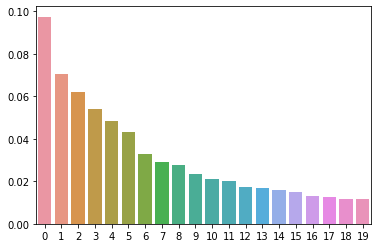

In [32]:
# data = ___________________ 부분을 채워 주세요!
sns.barplot(
    data= importanceOfPrincipalComponents.loc[:, 0:19]
)
plt.show()

In [33]:
#6] Clustering
#k-means Clustering의 결과를 시각적으로 확인해 봅시다!

#6]번 문제는 MNIST 데이터를 사용하지 않고,<br>
#scikit-learn의 make_blobs 함수를 사용해 연습용 데이터를 만들겠습니다.

#아래의 코드를 실행해 연습용 데이터를 생성하고, 이를 시각화해 주세요!<br>
#주의] 실행할 때마다 연습용 데이터가 달라지므로, **데이터가 너무 겹쳐 있는 경우 재실행**해 주세요.


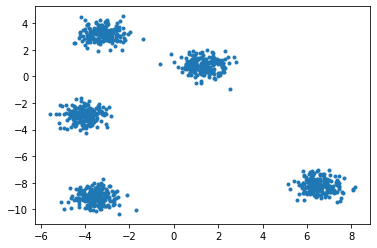

In [34]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

n_center = 5

# Example Data 생성
X, y = make_blobs(n_samples=1000, centers=n_center, cluster_std=0.5)
plt.scatter(X[:, 0], X[:, 1], marker='.')

In [35]:
#아래의 코드를 실행해 Clustering을 적용해 봅니다.

In [36]:
# Cluster 생성

k_means = KMeans(n_clusters=n_center, n_init=12)
k_means.fit(X)

k_means_labels = k_means.labels_
print('k_means_labels : ', k_means_labels)

k_means_cluster_centers = k_means.cluster_centers_
print('k_means_cluster_centers : ', k_means_cluster_centers)

k_means_labels :  [2 4 4 1 4 0 3 2 3 2 0 1 0 1 3 4 2 3 4 2 1 0 0 2 3 1 1 2 2 4 0 1 3 4 1 1 1
 3 1 0 1 2 4 1 2 3 2 3 1 2 4 2 2 0 2 2 1 3 4 3 1 2 2 4 4 1 0 1 4 3 2 4 2 0
 2 2 4 2 4 2 0 3 2 0 4 1 0 4 2 0 1 2 3 1 0 0 0 4 2 2 3 4 2 0 0 1 1 3 0 1 3
 1 4 1 0 2 2 1 1 3 2 4 1 3 1 2 2 4 3 3 0 3 4 2 3 1 0 0 2 3 0 0 2 3 3 3 3 2
 3 4 4 0 2 2 2 0 1 3 3 0 4 3 0 4 3 3 4 4 0 0 0 4 0 3 3 3 1 4 2 3 4 2 2 4 2
 3 1 3 1 3 2 1 1 2 4 4 1 0 2 4 3 1 3 0 3 4 0 4 4 3 3 4 3 4 1 4 0 0 2 2 1 3
 1 2 2 3 1 0 2 4 0 0 4 2 1 2 0 3 4 2 1 3 4 0 4 3 4 3 4 3 0 2 4 0 4 2 4 1 0
 0 3 4 2 3 3 0 2 3 1 0 2 2 2 0 0 2 1 0 4 4 2 4 2 4 1 0 1 1 0 1 3 4 0 1 3 1
 0 2 0 1 0 2 2 3 3 3 0 1 3 3 1 4 2 4 4 4 1 0 4 0 3 3 4 1 2 1 4 3 3 4 4 2 4
 4 0 3 1 4 3 0 2 3 4 3 0 2 2 1 3 2 4 3 2 3 2 0 2 4 3 0 2 3 0 0 4 3 3 3 3 3
 4 4 0 4 1 2 0 3 3 4 4 4 4 0 1 0 4 1 3 2 1 0 2 0 2 2 3 4 3 2 2 2 3 4 4 1 3
 4 3 4 2 2 1 0 4 1 3 0 0 2 1 3 4 1 4 4 1 3 4 3 1 0 3 3 1 2 2 3 4 4 4 1 3 0
 2 2 1 0 0 0 2 2 2 1 3 2 1 2 4 0 3 4 1 3 2 3 2 3 4 2 3 0 0 1 1 1 1 3 4 0 2
 2 2 2 

In [37]:
#마지막으로, 아래의 코드를 실행해
#k-means clustering의 결과물을 시각화해 주세요!

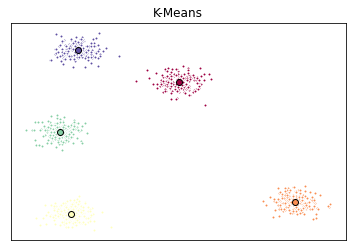

In [38]:
# 지정된 크기로 초기화
fig = plt.figure(figsize=(6, 4))

# 레이블 수에 따라 색상 배열 생성, 고유한 색상을 얻기 위해 set(k_means_labels) 설정
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# plot 생성
ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(n_center), colors):
    my_members = (k_means_labels == k)

    # 중심 정의
    cluster_center = k_means_cluster_centers[k]

    # 중심 그리기
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)

ax.set_title('K-Means')
ax.set_xticks(())
ax.set_yticks(())
plt.show()